In [0]:
import numpy as np
from numpy.random import sample
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras import initializers
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import layers
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras import models

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_abnormal = pd.read_csv("/content/drive/My Drive/ML/projects/ecg/data/ptbdb_abnormal.csv", header=None)
df_normal = pd.read_csv("/content/drive/My Drive/ML/projects/ecg/data/ptbdb_normal.csv", header=None)

# Stacks df_abnormal and df_normal
df = pd.concat([df_abnormal, df_normal], axis=0)
print("\ndf class counts")
print( df.iloc[:,187].value_counts() )
print("df.shape => ", df.shape )


df class counts
1.0    10506
0.0     4046
Name: 187, dtype: int64
df.shape =>  (14552, 188)


In [0]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.80, shuffle=True, random_state=1)

print("X_train.shape => ", X_train.shape )
print("y_train.shape => ", y_train.shape )
print("X_test.shape =>  ", X_test.shape )
print("y_test.shape =>  ", y_test.shape )

# Prepares data for CNN ##############################################################################

# Standardizes data
sc = StandardScaler(with_mean=True, with_std=True)
sc.fit(X_train)
x_train = sc.transform(X_train)
x_test = sc.transform(X_test)

# Reshapes arrays for cnn
n_steps = x_train.shape[1]
x_train = x_train.reshape(-1,n_steps,1)
x_test = x_test.reshape(-1,n_steps,1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("x_train.shape => ", x_train.shape)
print("x_test.shape  => ", x_test.shape)
print("y_train.shape => ", y_train.shape)
print("y_test.shape  => ", y_test.shape)

X_train.shape =>  (11641, 187)
y_train.shape =>  (11641,)
X_test.shape =>   (2911, 187)
y_test.shape =>   (2911,)
x_train.shape =>  (11641, 187, 1)
x_test.shape  =>  (2911, 187, 1)
y_train.shape =>  (11641, 2)
y_test.shape  =>  (2911, 2)


In [0]:
init = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=1)
input = layers.Input(shape=(n_steps,1)) 
conv1 = layers.convolutional.Conv1D( filters=32, kernel_size=(5), activation='relu', 
                                     #activity_regularizer=regularizers.l2(0.01), 
                                     use_bias=True,bias_initializer=init, 
                                     kernel_initializer=init )(input) 
conv2 = layers.convolutional.Conv1D( filters=32, kernel_size=(5), activation='relu', 
                                     #activity_regularizer=regularizers.l2(0.01), 
                                     use_bias=True,bias_initializer=init, 
                                     kernel_initializer=init )(conv1) 
pool1 = layers.MaxPooling1D(pool_size=3)(conv2)

conv3 = layers.convolutional.Conv1D( filters=32, kernel_size=(5), activation='relu', 
                                     #activity_regularizer=regularizers.l2(0.01), 
                                     use_bias=True,bias_initializer=init, 
                                     kernel_initializer=init )(pool1) 
conv4 = layers.convolutional.Conv1D( filters=32, kernel_size=(5), activation='relu', 
                                     #activity_regularizer=regularizers.l2(0.01), 
                                     use_bias=True,bias_initializer=init, 
                                     kernel_initializer=init )(conv3) 
pool2 = layers.MaxPooling1D(pool_size=3)(conv4)
drop = layers.Dropout(0.5)(pool2)

flat = layers.Flatten()(drop)

dense1 = layers.Dense( 32,activation='relu', use_bias=True, bias_initializer=init, kernel_initializer=init )(flat) 
dense2 = layers.Dense( 2,activation='softmax', use_bias=True, bias_initializer=init, kernel_initializer=init )(dense1)

model = models.Model(inputs=input, outputs=dense2) 
optim = optimizers.RMSprop(lr=0.0007) 
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'] )

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 183, 32)           192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 32)           5152      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 59, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 32)            5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 51, 32)            5152      
_________

Train on 9312 samples, validate on 2329 samples
Epoch 1/150
9312/9312 [==============================] - 5s 490us/sample - loss: 5.2753 - acc: 0.6796 - val_loss: 0.6925 - val_acc: 0.7600
Epoch 2/150
9312/9312 [==============================] - 1s 81us/sample - loss: 1.0939 - acc: 0.7226 - val_loss: 0.4622 - val_acc: 0.7875
Epoch 3/150
9312/9312 [==============================] - 1s 76us/sample - loss: 0.6165 - acc: 0.7504 - val_loss: 0.3947 - val_acc: 0.8210
Epoch 4/150
9312/9312 [==============================] - 1s 78us/sample - loss: 0.4703 - acc: 0.7875 - val_loss: 0.3521 - val_acc: 0.8523
Epoch 5/150
9312/9312 [==============================] - 1s 73us/sample - loss: 0.4034 - acc: 0.8155 - val_loss: 0.3096 - val_acc: 0.8763
Epoch 6/150
9312/9312 [==============================] - 1s 75us/sample - loss: 0.3613 - acc: 0.8388 - val_loss: 0.2901 - val_acc: 0.8862
Epoch 7/150
9312/9312 [==============================] - 1s 75us/sample - loss: 0.3369 - acc: 0.8530 - val_loss: 0.2327 - v

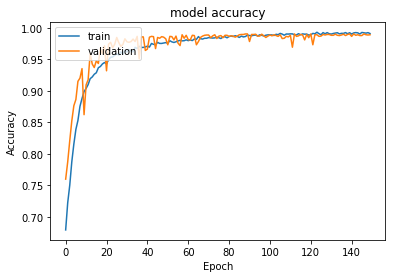

2911/2911 [==============================] - 0s 137us/sample - loss: 0.0838 - acc: 0.9856
Accuracy =>  [0.08376692286703458, 0.985572]


In [0]:
batch_size = 128

history = model.fit(x_train, y_train, epochs=150, shuffle=False, batch_size=batch_size, verbose=1, validation_split=0.2)
# max in epoch = 280

# Prints model loss and validation accuracy vs epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print("Accuracy => ", model.evaluate(x_test, y_test))